In [154]:
#pip install geopandas
#pip install geodatasets
#pip install cartopy

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd 
import geodatasets
import matplotlib.colors as mcolors
from datetime import datetime
from shapely.geometry import Point
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.patches import FancyArrowPatch
from matplotlib.ticker import MaxNLocator

In [2]:
df=pd.read_csv('spacex_launch_data.csv.xls')
#df.head()

In [3]:
# Rename columns
df.rename(columns={df.columns[2]: 'Time', 
                   df.columns[5]: 'Payload.Name', 
                   df.columns[6]: 'Payload.Mass'}, inplace=True)

# Convert 'Date' column to datetime and extract 'Year'
df['DateTS'] = pd.to_datetime(df['Date'])
df['Year'] = df['DateTS'].dt.year

# Clean 'Landing.Outcome' column
df['Landing.Outcome.v2'] = df['Landing Outcome'].str.replace("   ", " ").str.replace("  ", " ")

# Clean and extract 'Launch.Site.v2' before '('
df['Launch.Site.v2'] = df['Launch Site'].apply(lambda x: x.split("(")[0].strip())

# Function to determine Landing Outcome
def make_landing_outcome(x):
    y = x.split(" ")[0]  # Extract first word
    return 'No Attempt' if y == 'No' else y

df['Landing.Outcome.v3'] = df['Landing.Outcome.v2'].apply(make_landing_outcome)

# Clean and convert 'Payload.Mass' to numeric
df['Payload.Mass'] = df['Payload.Mass'].astype(str).str.strip()
df['Payload.Mass'] = df['Payload.Mass'].str.replace(",", "").str.replace("~", "")
df['Payload.Mass'] = pd.to_numeric(df['Payload.Mass'], errors='coerce')  # Convert to numeric, handling errors

# Display the DataFrame
df.head()

,Flight Number,Date,Time,Booster Version,Launch Site,Payload.Name,Payload.Mass,Orbit,Customer,Mission Outcome,Landing Outcome,DateTS,Year,Landing.Outcome.v2,Launch.Site.v2,Landing.Outcome.v3
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX,Success,Failure (parachute),2010-06-04,2010,Failure (parachute),CCAFS LC-40,Failure
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",NaN,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute),2010-12-08,2010,Failure (parachute),CCAFS LC-40,Failure
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),Success,No attempt,2012-05-22,2012,No attempt,CCAFS LC-40,No Attempt
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),Success,No attempt,2012-10-08,2012,No attempt,CCAFS LC-40,No Attempt
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),Success,No attempt,2013-03-01,2013,No attempt,CCAFS LC-40,No Attempt


### Plotting

In [4]:
plt.style.use('fivethirtyeight')

In [5]:
# Extract unique launch sites
launch_sites = df['Launch.Site.v2'].unique()

# Define launch names
launch_names = [
    'CAPE CANAVERAL AIR FORCE STATION SPACE LAUNCH COMPLEX 40',
    'VANDENBERG AFB SPACE LAUNCH COMPLEX 4',
    'KENNEDY SPACE CENTER LAUNCH COMPLEX 39',
    'CAPE CANAVERAL AIR FORCE STATION SPACE LAUNCH COMPLEX 40'
]

# Define coordinates
launch_lat = [28.40584, 34.632706, 28.6050359132, 28.562106]
launch_long = [-80.60477, -120.613393, -80.6026042562, -80.57718]

# Create a DataFrame
geo_data = pd.DataFrame({
    'Launch.Name': launch_names,
    'Launch.Site': launch_sites,
    'long': launch_long,
    'lat': launch_lat
})

# Define landing outcomes and colors
outcomes = sorted(df['Landing.Outcome.v3'].unique())

color_mapping = {
    'SUCCESS': '#008000',  # Green
    'FAILURE': '#FF0000',  # Red
    'NO ATTEMPT': '#808080',  # Gray
    'PRECLUDED': '#FFA500'  # Orange
}

# Assign colors to outcomes
color_df = pd.DataFrame({
    'Landing.Outcome.v3': outcomes,
    'color': [color_mapping.get(outcome, '#000000') for outcome in outcomes]  # Default black for unknown outcomes
})

# Display results
print("Launch Site Data:")
print(geo_data)

print("\nLanding Outcome Colors:")
print(color_df)

Launch Site Data:
                                         Launch.Name   Launch.Site  \
0  CAPE CANAVERAL AIR FORCE STATION SPACE LAUNCH ...   CCAFS LC-40   
1              VANDENBERG AFB SPACE LAUNCH COMPLEX 4   VAFB SLC-4E   
2             KENNEDY SPACE CENTER LAUNCH COMPLEX 39    KSC LC-39A   
3  CAPE CANAVERAL AIR FORCE STATION SPACE LAUNCH ...  CCAFS SLC-40   

         long        lat  
0  -80.604770  28.405840  
1 -120.613393  34.632706  
2  -80.602604  28.605036  
3  -80.577180  28.562106  

Landing Outcome Colors:
  Landing.Outcome.v3    color
0         Controlled  #000000
1            Failure  #000000
2         No Attempt  #000000
3          Precluded  #000000
4            Success  #000000
5       Uncontrolled  #000000


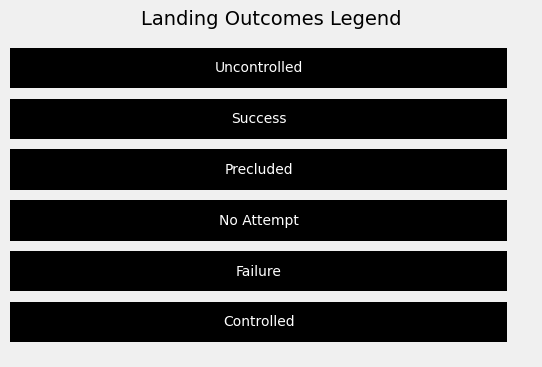

In [6]:
# Legend plot data
plt.figure(figsize=(6, 4))
for outcome, color in zip(color_df['Landing.Outcome.v3'], color_df['color']):
    plt.barh(outcome, 1, color=color)

plt.gca().axis('off')  # Remove axes
plt.title('Landing Outcomes Legend', fontsize=14)
for idx, outcome in enumerate(color_df['Landing.Outcome.v3']):
    plt.text(0.5, idx, outcome, ha='center', va='center', color='white', fontsize=10)


In [8]:
df.rename(columns={'Launch Site': 'Launch.Site'}, inplace=True)

# Merge dataframes
RES = df.merge(geo_data, on='Launch.Site', how='left').merge(color_df, on='Landing.Outcome.v3', how='left')

# Create summary data for plotting
temp = (
    df.groupby('Launch.Site')
    .size()
    .reset_index(name='count')
    .merge(geo_data, on='Launch.Site', how='left')
)

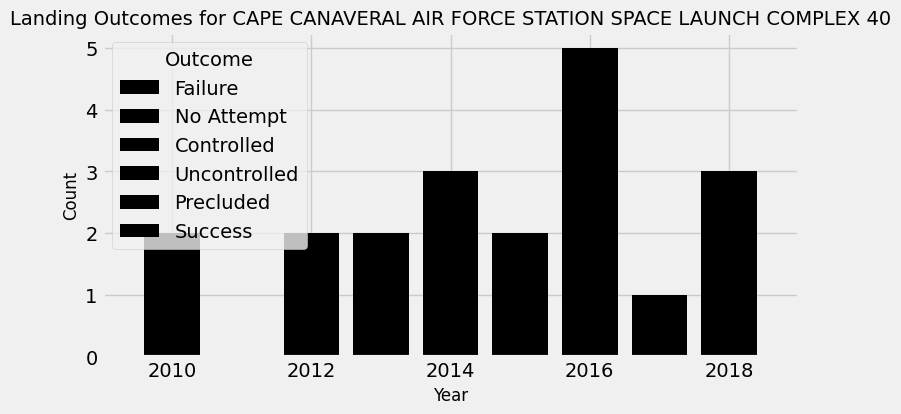

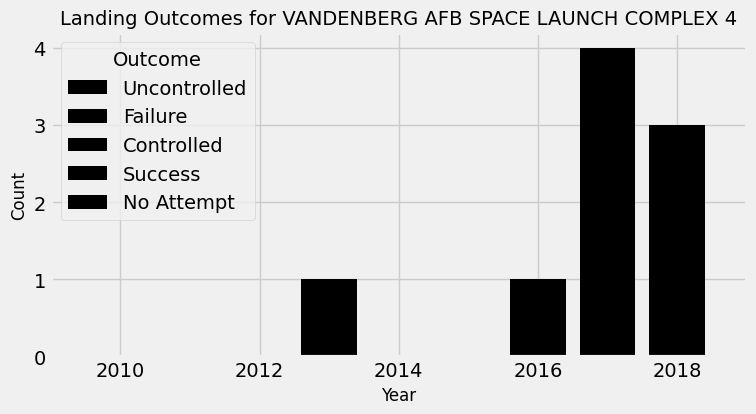

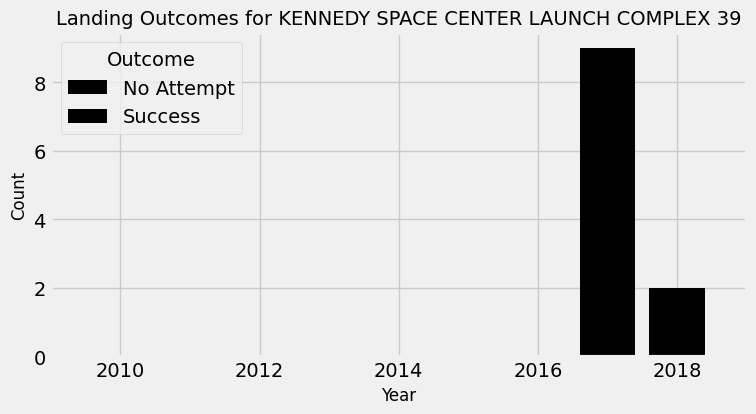

In [9]:
# Create histograms for each unique launch site
mylist = {}
for site in RES['Launch.Name'].unique():
    # Filter data for the specific launch site
    site_data = (
        RES[RES['Launch.Name'] == site]
        .groupby(['Year', 'Landing.Outcome.v3'])
        .size()
        .reset_index(name='count')
    )
    
    # Create the histogram
    fig, ax = plt.subplots(figsize=(8, 4))
    legend_labels = set()  # Keep track of added labels to avoid duplicates
    
    for _, row in site_data.iterrows():
        outcome = row['Landing.Outcome.v3']
        color = color_mapping.get(outcome, "black")  # Map color based on outcome
        if outcome not in legend_labels:  # Only add label once
            ax.bar(row['Year'], row['count'], color=color, label=outcome)
            legend_labels.add(outcome)  # Mark label as added
        else:
            ax.bar(row['Year'], row['count'], color=color)  # No label for duplicates
    
    ax.set_title(f'Landing Outcomes for {site}', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlim(2009, 2019)
    ax.legend(title='Outcome')
    mylist[site] = fig

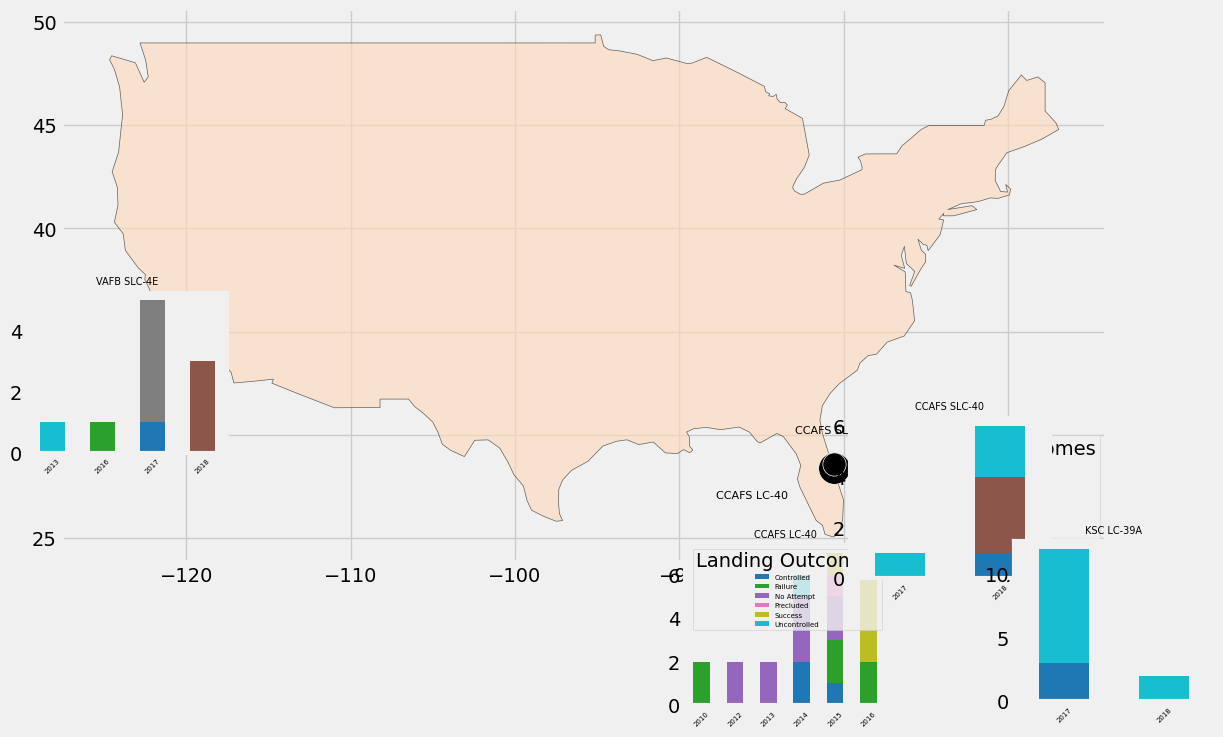

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.patches import FancyArrowPatch

# Load USA shapefile
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
usa = world[world['NAME'] == 'United States of America']

from shapely.geometry import box

# Define a bounding box for the continental US (roughly)
lower_48 = box(-125, 24, -66, 50)  # (minx, miny, maxx, maxy)

# Clip the USA map to this bounding box
usa = usa.intersection(lower_48)

# Create GeoDataFrame for launch sites
geometry = [Point(xy) for xy in zip(temp['long'], temp['lat'])]
geo_temp = gpd.GeoDataFrame(temp, geometry=geometry)

# Function to determine offset dynamically to avoid overlap
def get_offset(index):
    spacing_x = 10  # Increased spacing for better separation
    spacing_y = 6
    return (index % 3 - 1) * spacing_x, (index % 2 - 0.5) * spacing_y

# Set up figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
usa.plot(ax=ax, color="peachpuff", edgecolor="black", alpha=0.6)

# Color mapping for outcomes
color_mapping = {
    "Controlled": "#FFA500",
    "Failure": "#FF0000",
    "No Attempt": "#800080",
    "Precluded": "#808080",
    "Success": "#008000",
    "Uncontrolled": "#6495ED",
}

# Add histograms without overlap
for idx, (_, site) in enumerate(geo_temp.iterrows()):
    x, y = site.geometry.x, site.geometry.y
    dx, dy = get_offset(idx)
    ax.scatter(x, y, s=site['count'] * 20, color="black", edgecolor="white", zorder=5)
    ax.annotate(site['Launch.Site'], (x + dx / 2, y + dy / 2), fontsize=8, ha='center')
    
    # Adjust inset size and position to improve spacing
    inset_ax = inset_axes(ax, width=2.0, height=1.6, loc="upper left", 
                          bbox_to_anchor=(x + dx, y + dy, 0, 0), bbox_transform=ax.transData, borderpad=0.8)
    
    site_data = RES[RES['Launch.Site'] == site['Launch.Site']]
    if not site_data.empty:
        grouped_data = site_data.groupby(['Year', 'Landing.Outcome.v3']).size().unstack(fill_value=0)
        grouped_data.plot(kind='bar', stacked=True, ax=inset_ax, colormap="tab10")
        
        inset_ax.set_title(f"{site['Launch.Site']}", fontsize=7)
        inset_ax.tick_params(axis='x', labelsize=5, rotation=45)
        inset_ax.set_xlabel("")
        inset_ax.set_ylabel("")
        inset_ax.grid(False)
        
        # Only add legend once
        if idx == 0:
            inset_ax.legend(title='Landing Outcomes', fontsize=5, loc='upper right')
        else:
            inset_ax.get_legend().remove()

# Add legend for colors
legend_elements = [mpatches.Patch(color=color, label=outcome) for outcome, color in color_mapping.items()]
ax.legend(handles=legend_elements, loc='lower right', title='Landing Outcomes', fontsize=8)

plt.show()


